In [2]:
import os

# Set the directory
new_directory = r"C:\Users\Farha Tarique\Documents\AI_project\raw\21_nov"
os.chdir(new_directory)

# Verify the change
print("Current Working Directory:", os.getcwd())


Current Working Directory: C:\Users\Farha Tarique\Documents\AI_project\raw\21_nov


In [3]:
# Run these one by one in cells
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install matplotlib-venn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import (roc_curve, auc, roc_auc_score, r2_score, 
                            mean_squared_error, classification_report, 
                            confusion_matrix)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


In [5]:

#==============================================================================
# YOUR EXISTING CODE (Steps 1-8)
#==============================================================================

df = pd.read_csv("gene_counts_ml.csv")  

# Merge and fillna with zero
df = df.fillna(0)
print(f"Initial data shape: {df.shape}")
df.set_index("Geneid")
df_T = df.transpose(copy=True)

# Set proper column names
header_row = df_T.loc["Geneid"]
df_T.columns = header_row
df_T = df_T.drop("Geneid")
df_transposed = df_T.reset_index()
df_transposed.rename(columns={'index': 'Geneid'}, inplace=True)

# Load samples information
df_S = pd.read_csv("metadata.csv")
print("\nOriginal metadata:")
print(df_S.head())
df_S = df_S.replace({"Tumor":1, "Native tissue":0})
print("\nEncoded metadata:")
print(df_S.head())


Initial data shape: (8914, 145)

Original metadata:
        Sample condition
0  SRR12475103     Tumor
1  SRR12475104     Tumor
2  SRR12475105     Tumor
3  SRR12475106     Tumor
4  SRR12475107     Tumor

Encoded metadata:
        Sample  condition
0  SRR12475103          1
1  SRR12475104          1
2  SRR12475105          1
3  SRR12475106          1
4  SRR12475107          1


In [6]:

# Merge samples and expression values
data_feature = pd.merge(df_transposed, df_S, right_on="Sample", left_on="Geneid", how="inner")
print(f"\nMerged data shape: {data_feature.shape}")

# Prepare features and labels
feature = data_feature.drop(columns=["Geneid", "condition", "Sample"])
sample = data_feature.iloc[:, -1]
all_columns = list(data_feature.columns)
columns_to_keep = [col for col in all_columns if col not in ["Geneid", "condition", "Sample"]]
print(f"Number of features: {len(columns_to_keep)}")



Merged data shape: (144, 8917)
Number of features: 8914


In [7]:

# Scale the data
scaler = RobustScaler()
correct_columns = list(data_feature.columns[:-1])
correct_columns.remove("Geneid")
feature_scaled = pd.DataFrame(scaler.fit_transform(feature), 
                              index=feature.index, 
                              columns=columns_to_keep)


In [8]:
#print(f"After low-variance removal: {X_reduced.shape[1]} genes")


In [9]:
# biomarker_pipeline_lasso_svm.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib_venn import venn2
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# ----------------------------
# OUTPUT DIR
# ----------------------------
OUTDIR = "figures_and_tables_lasso_svm"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------------------
# CHECK required variables
# The script expects these variables pre-defined in your environment:
#   - feature : pandas.DataFrame (rows=samples, cols=genes)
#   - data_feature : pandas.DataFrame (optional, used if columns_to_keep not provided)
#   - columns_to_keep : list of gene column names (optional)
#   - sample : array-like labels (length matches feature.shape[0])
# ----------------------------
for name in ["feature", "sample"]:
    if name not in globals():
        raise RuntimeError(f"Required variable '{name}' not found. Define it before running this script.")

# If columns_to_keep not provided, try derive from data_feature or feature
if "columns_to_keep" not in globals():
    if "data_feature" in globals():
        # attempt: all columns except 'Geneid' if present, otherwise all feature columns
        cols = list(data_feature.columns)
        if "Geneid" in cols:
            cols.remove("Geneid")
        columns_to_keep = cols
    else:
        columns_to_keep = list(feature.columns)
else:
    # ensure columns exist in feature
    columns_to_keep = [c for c in columns_to_keep if c in feature.columns]

if len(columns_to_keep) == 0:
    raise RuntimeError("No gene columns found in 'columns_to_keep' or 'data_feature'. Please check variable names.")

# ----------------------------
# SCALE the data (RobustScaler)
# The user-supplied line had minor issues; we create the scaled DataFrame properly.
# ----------------------------
scaler = RobustScaler()
feature_scaled = pd.DataFrame(
    scaler.fit_transform(feature[columns_to_keep]),
    index=feature.index,
    columns=columns_to_keep
)

print(f"feature_scaled shape: {feature_scaled.shape}")

# ----------------------------
# Encode labels for sklearn (binary)
# ----------------------------
y = np.array(sample)
if y.dtype == object or y.dtype.kind in {'U', 'S'}:
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
else:
    y_enc = y

unique_labels = np.unique(y_enc)
if unique_labels.shape[0] != 2:
    raise RuntimeError(f"Labels are not binary (found {unique_labels}). ROC and many metrics require binary labels.")

# ----------------------------
# 1) LASSO (L1 Logistic) with CV for C
# ----------------------------
print("\n=== LASSO (L1 logistic) feature selection ===")
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
C_values = np.logspace(-4, -1, 10)

grid = GridSearchCV(logreg, {"C": C_values}, scoring="accuracy", cv=5, n_jobs=-1)
grid.fit(feature_scaled, y_enc)
best_C = grid.best_params_["C"]
print("Best LASSO C:", best_C)

lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=5000)
lasso_model.fit(feature_scaled, y_enc)

# get non-zero coefficients
coef = lasso_model.coef_.ravel()
nonzero_mask = coef != 0
lasso_genes = feature_scaled.columns[nonzero_mask].tolist()
lasso_coeffs = coef[nonzero_mask]
print(f"LASSO selected {len(lasso_genes)} genes")

# save
pd.DataFrame({"Gene": lasso_genes, "Coefficient": lasso_coeffs}).to_csv(
    os.path.join(OUTDIR, "lasso_selected_genes.csv"), index=False)

# ----------------------------
# 2) SVM-RFE (use only LASSO-selected genes as input)
# ----------------------------
print("\n=== SVM-RFE feature selection (using LASSO genes as input) ===")
if len(lasso_genes) == 0:
    raise RuntimeError("LASSO selected 0 genes — cannot run SVM-RFE on empty set. Consider relaxing LASSO penalty.")

X_lasso = feature_scaled[lasso_genes]
svm_est = SVC(kernel="linear", probability=False)  # no probabilities required for RFE
# pick n_features_to_select safely
n_select = min(20, X_lasso.shape[1])
if n_select < 1:
    raise RuntimeError("Not enough features for RFE selection.")
selector = RFE(estimator=svm_est, n_features_to_select=n_select, step=1)
selector = selector.fit(X_lasso, y_enc)
svm_genes = X_lasso.columns[selector.support_].tolist()
print(f"SVM-RFE selected {len(svm_genes)} genes (requested {n_select})")

pd.DataFrame({"Gene": svm_genes}).to_csv(os.path.join(OUTDIR, "svm_rfe_selected_genes.csv"), index=False)

# ----------------------------
# 3) Intersection consensus: LASSO ∩ SVM-RFE
# ----------------------------
core_genes = sorted(list(set(lasso_genes).intersection(set(svm_genes))))
print("\nCore genes (LASSO ∩ SVM-RFE):", len(core_genes))
pd.DataFrame({"Gene": core_genes}).to_csv(os.path.join(OUTDIR, "core_genes_lasso_svm.csv"), index=False)

# ----------------------------
# 4) Save union and a small summary table
# ----------------------------
union_genes = sorted(list(set(lasso_genes) | set(svm_genes)))
summary_df = pd.DataFrame({
    "Model": ["LASSO", "SVM-RFE", "Intersection(LASSO∩SVM)"],
    "n_genes": [len(lasso_genes), len(svm_genes), len(core_genes)]
})
summary_df.to_csv(os.path.join(OUTDIR, "selection_summary.csv"), index=False)


feature_scaled shape: (144, 8914)

=== LASSO (L1 logistic) feature selection ===
Best LASSO C: 0.021544346900318822
LASSO selected 48 genes

=== SVM-RFE feature selection (using LASSO genes as input) ===
SVM-RFE selected 20 genes (requested 20)

Core genes (LASSO ∩ SVM-RFE): 20


In [46]:
# ----------------------------
# 5) Predictive Performance Evaluation (Accuracy, F1, Precision, Recall, AUC)
# ----------------------------
print("\n=== Predictive Performance Evaluation ===")
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------- LASSO Logistic Regression Performance ----------
print("\n--- LASSO Logistic Regression Performance ---")

lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=5000)

y_pred_lasso = cross_val_predict(lasso_clf, feature_scaled[lasso_genes], y_enc, cv=cv)
auc_lasso = roc_auc_score(y_enc, y_pred_lasso)
acc_lasso = accuracy_score(y_enc, y_pred_lasso)
f1_lasso = f1_score(y_enc, y_pred_lasso)
prec_lasso = precision_score(y_enc, y_pred_lasso)
rec_lasso = recall_score(y_enc, y_pred_lasso)
cm_lasso = confusion_matrix(y_enc, y_pred_lasso)

print(f"LASSO Accuracy : {acc_lasso:.4f}")
print(f"LASSO F1-score : {f1_lasso:.4f}")
print(f"LASSO Precision: {prec_lasso:.4f}")
print(f"LASSO Recall   : {rec_lasso:.4f}")
print(f"LASSO ROC-AUC  : {auc_lasso:.4f}")
print("\nLASSO Confusion Matrix:\n", cm_lasso)


# ---------- SVM Performance (using SVM-RFE genes) ----------
print("\n--- SVM Performance (RFE-selected genes) ---")

svm_clf = SVC(kernel="linear")

y_pred_svm = cross_val_predict(svm_clf, feature_scaled[svm_genes], y_enc, cv=cv)
acc_svm = accuracy_score(y_enc, y_pred_svm)
f1_svm = f1_score(y_enc, y_pred_svm)
prec_svm = precision_score(y_enc, y_pred_svm)
rec_svm = recall_score(y_enc, y_pred_svm)
auc_svm = roc_auc_score(y_enc, y_pred_svm)
cm_svm = confusion_matrix(y_enc, y_pred_svm)

print(f"SVM Accuracy : {acc_svm:.4f}")
print(f"SVM F1-score : {f1_svm:.4f}")
print(f"SVM Precision: {prec_svm:.4f}")
print(f"SVM Recall   : {rec_svm:.4f}")
print(f"SVM ROC-AUC  : {auc_svm:.4f}")
print("\nSVM Confusion Matrix:\n", cm_svm)


# ---------- Save all metrics ----------
metrics_df = pd.DataFrame({
    "Model": ["LASSO_LogReg", "SVM_RFE"],
    "Accuracy": [acc_lasso, acc_svm],
    "F1_score": [f1_lasso, f1_svm],
    "Precision": [prec_lasso, prec_svm],
    "Recall": [rec_lasso, rec_svm],
    "ROC_AUC": [auc_lasso, auc_svm]
})

metrics_df.to_csv(os.path.join(OUTDIR, "model_performance_metrics.csv"), index=False)

print("\nPerformance metrics saved to:", os.path.join(OUTDIR, "model_performance_metrics.csv"))



=== Predictive Performance Evaluation ===

--- LASSO Logistic Regression Performance ---
LASSO Accuracy : 0.9097
LASSO F1-score : 0.9065
LASSO Precision: 0.9403
LASSO Recall   : 0.8750
LASSO ROC-AUC  : 0.9097

LASSO Confusion Matrix:
 [[68  4]
 [ 9 63]]

--- SVM Performance (RFE-selected genes) ---
SVM Accuracy : 0.9444
SVM F1-score : 0.9429
SVM Precision: 0.9706
SVM Recall   : 0.9167
SVM ROC-AUC  : 0.9444

SVM Confusion Matrix:
 [[70  2]
 [ 6 66]]

Performance metrics saved to: figures_and_tables_lasso_svm\model_performance_metrics.csv


Saved Venn diagram (PNG + PDF + SVG)


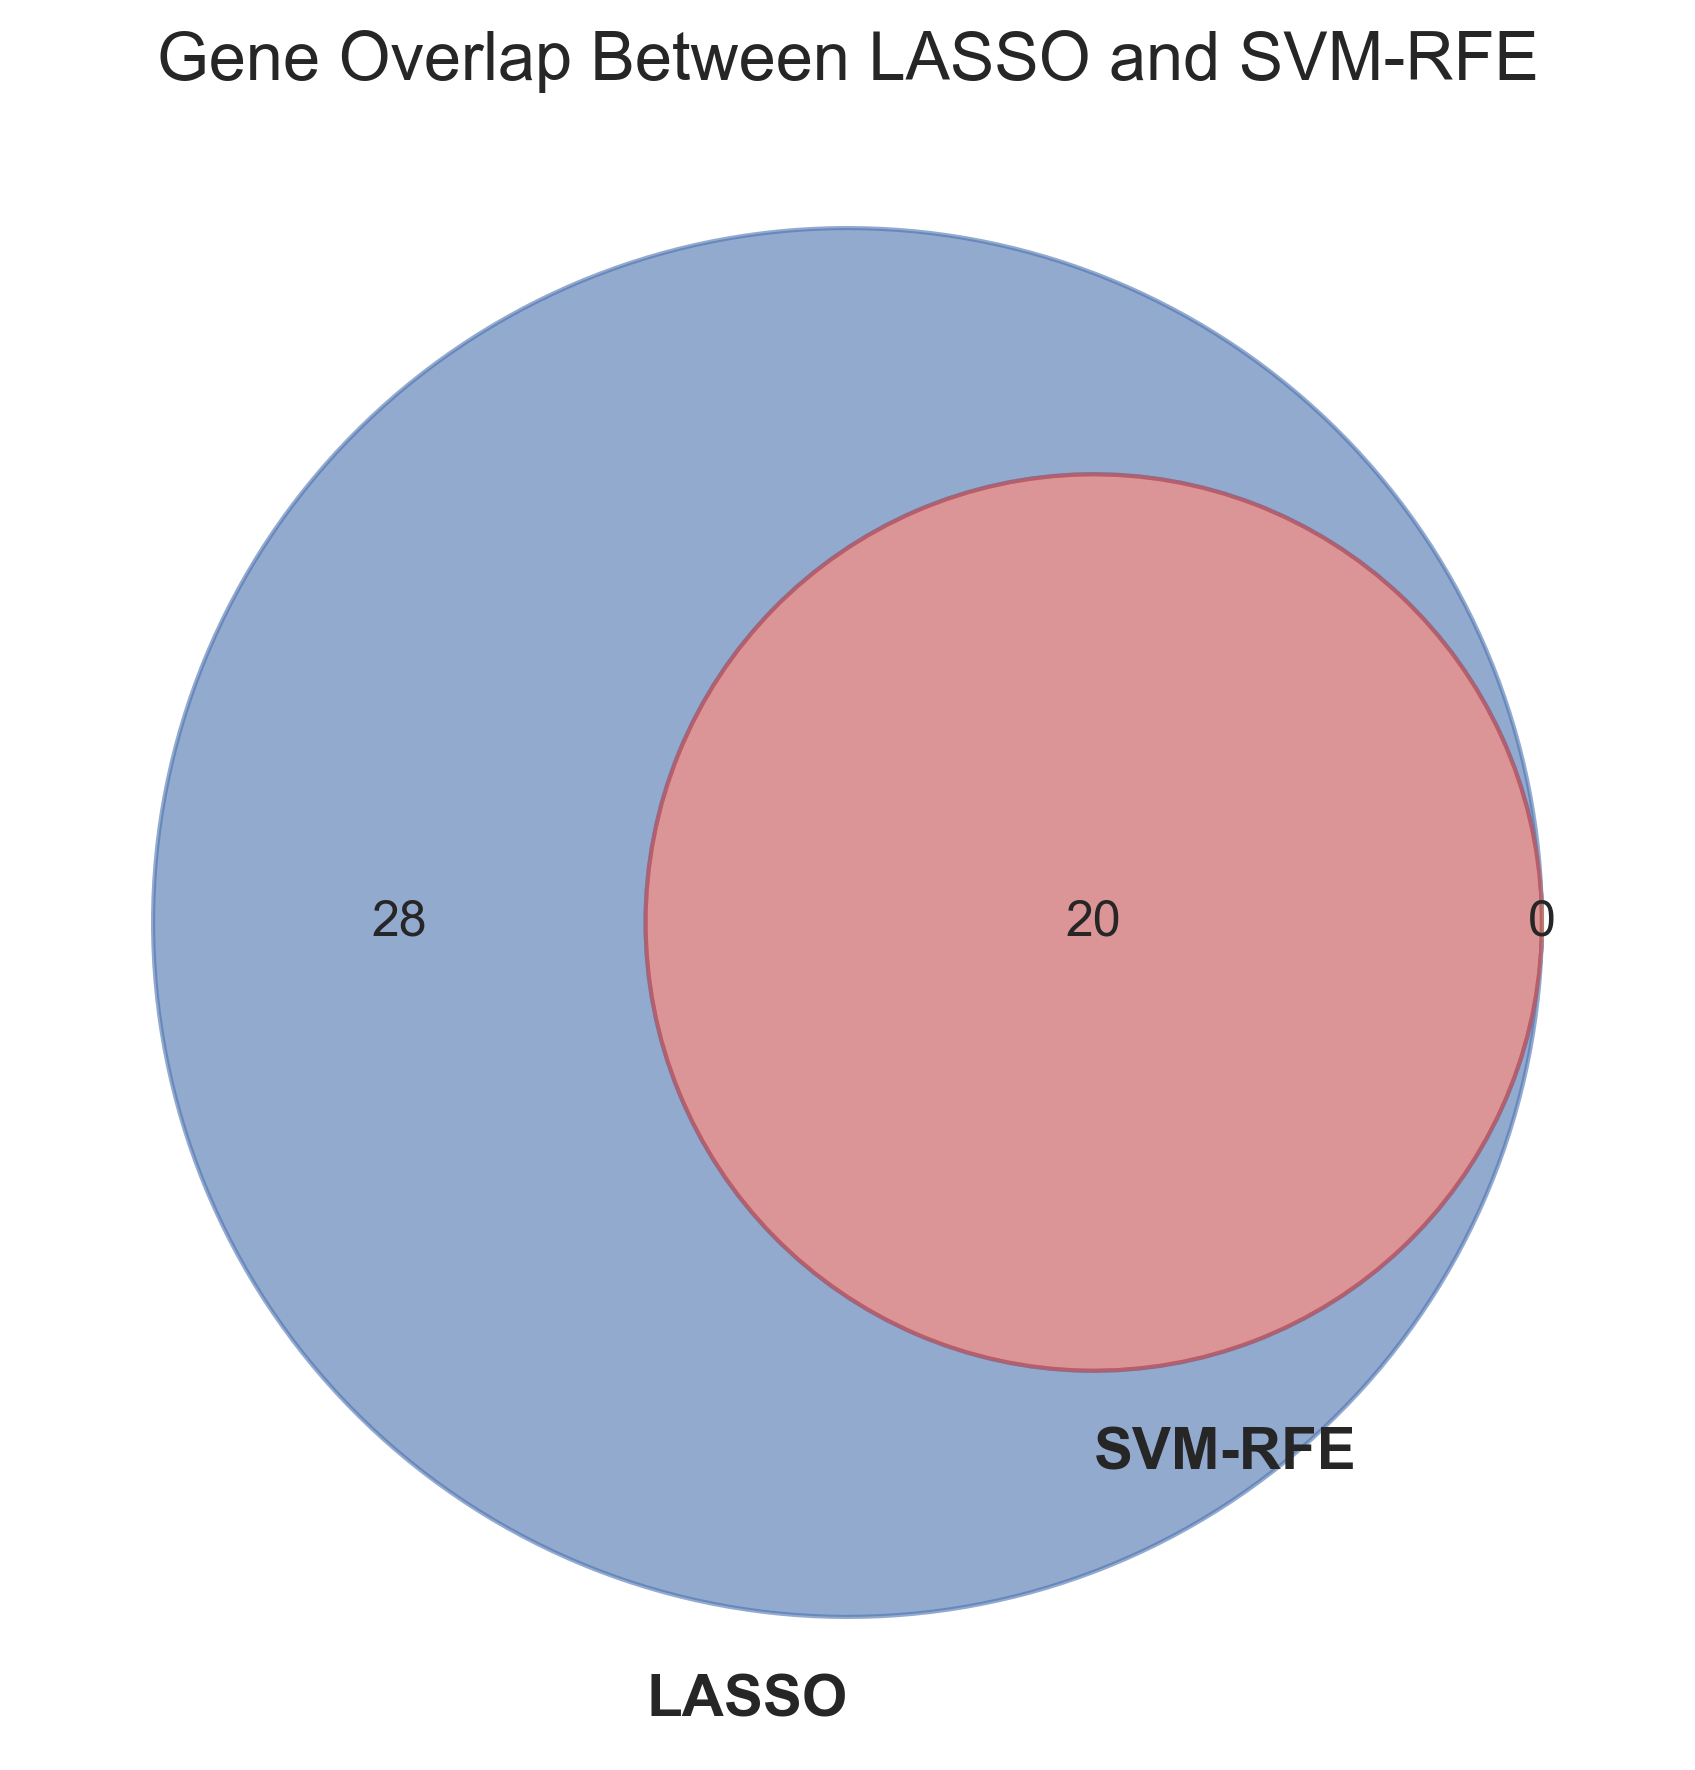

In [10]:
# ----------------------------
# 5) Venn diagram (LASSO vs SVM) For Publication purpose only.
# ----------------------------
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import os

try:
    plt.figure(figsize=(6, 6), dpi=300)

    # Create Venn diagram
    v = venn2(
        [set(lasso_genes), set(svm_genes)],
        set_labels=("LASSO", "SVM-RFE")
    )

    # Improve text styling
    for text in v.set_labels:
        if text:
            text.set_fontsize(14)
            text.set_fontweight('bold')

    for text in v.subset_labels:
        if text:
            text.set_fontsize(12)

    # Optional: subtle colors suitable for publication
    v.get_patch_by_id('10').set_color("#4C72B0")
    v.get_patch_by_id('01').set_color("#55A868")
    v.get_patch_by_id('11').set_color("#C44E52")

    for region in ['10', '01', '11']:
        if v.get_patch_by_id(region):
            v.get_patch_by_id(region).set_alpha(0.6)

    plt.title("Gene Overlap Between LASSO and SVM-RFE", fontsize=16)

    plt.tight_layout()

    # Save as PNG + vector formats (recommended for journals)
    plt.savefig(os.path.join(OUTDIR, "venn_lasso_svm.png"), dpi=600)
    plt.savefig(os.path.join(OUTDIR, "venn_lasso_svm.pdf"))  # vector
    plt.savefig(os.path.join(OUTDIR, "venn_lasso_svm.svg"))  # vector

    print("Saved Venn diagram (PNG + PDF + SVG)")

except Exception as e:
    print("Could not draw Venn diagram:", str(e))


Saved Venn diagram


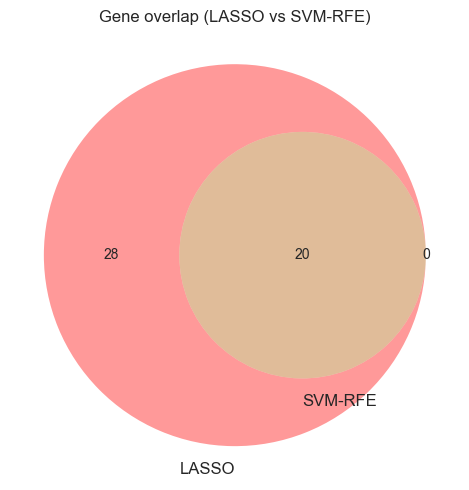

In [11]:

# ----------------------------
# 5) Venn diagram (LASSO vs SVM)
# ----------------------------
try:
    plt.figure(figsize=(5,5))
    venn2([set(lasso_genes), set(svm_genes)], set_labels=("LASSO", "SVM-RFE"))
    plt.title("Gene overlap (LASSO vs SVM-RFE)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "venn_lasso_svm.png"), dpi=300)
    #plt.close()
    print("Saved Venn diagram")
except Exception as e:
    print("Could not draw Venn diagram:", e)


Saved heatmap: figures_and_tables_lasso_svm\heatmap_core_genes.png, figures_and_tables_lasso_svm\heatmap_core_genes.pdf, figures_and_tables_lasso_svm\heatmap_core_genes.svg


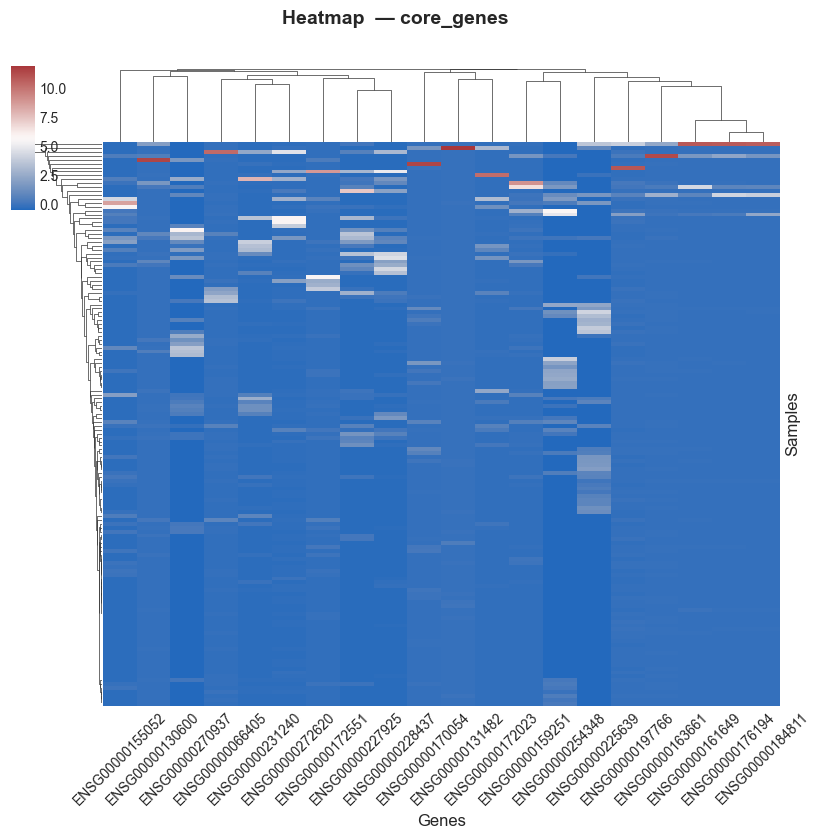

In [12]:
# ----------------------------
# 6) Heatmap of core genes (publication quality)
# ----------------------------
def plot_heatmap_genes(gene_list, fname, figsize=(8, 8)):
    if len(gene_list) == 0:
        print(f"No genes to plot for {fname}")
        return

    data = feature_scaled[gene_list].copy()

    # Z-score normalization per gene
    data_z = data.apply(zscore, axis=0)

    # Create cluster map
    g = sns.clustermap(
        data_z,
        cmap="vlag",                # publication-friendly colormap
        figsize=figsize,
        xticklabels=True,
        yticklabels=False,
        dendrogram_ratio=(0.12, 0.12),
        cbar_pos=(0.02, 0.8, 0.03, 0.18),   # slimmer colorbar
    )

    # Improve aesthetics
    g.ax_heatmap.set_xlabel("Genes", fontsize=12)
    g.ax_heatmap.set_ylabel("Samples", fontsize=12)

    # Clean up tick label size
    g.ax_heatmap.tick_params(axis='x', labelsize=10, rotation=45)

    # Modern, clean title
    g.fig.suptitle(f"Heatmap  — {fname}",
                   y=1.05, fontsize=14, fontweight='bold')

    # Output paths
    png_out = os.path.join(OUTDIR, f"heatmap_{fname}.png")
    pdf_out = os.path.join(OUTDIR, f"heatmap_{fname}.pdf")
    svg_out = os.path.join(OUTDIR, f"heatmap_{fname}.svg")

    # Save in multiple formats
    g.savefig(png_out, dpi=600, bbox_inches="tight")
    g.savefig(pdf_out, bbox_inches="tight")
    g.savefig(svg_out, bbox_inches="tight")

    #plt.close()
    print(f"Saved heatmap: {png_out}, {pdf_out}, {svg_out}")


# Run for core genes
plot_heatmap_genes(core_genes, "core_genes")


In [13]:

# ----------------------------
# 6) Heatmap of core genes (if any)
# ----------------------------
def plot_heatmap_genes(gene_list, fname, figsize=(8,6)):
    if len(gene_list) == 0:
        print(f"No genes to plot for {fname}")
        return
    data = feature_scaled[gene_list].copy()
    # z-score per gene (columns)
    data_z = data.apply(zscore, axis=0)
    # cluster map
    g = sns.clustermap(data_z, cmap="vlag", figsize=figsize, xticklabels=False, yticklabels=False)
    g.fig.suptitle(f"Heatmap (z-score) — {fname}", y=1.02)
    outp = os.path.join(OUTDIR, f"heatmap_{fname}.png")
    plt.savefig(outp, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved heatmap:", outp)

plot_heatmap_genes(core_genes, "core_genes")


Saved heatmap: figures_and_tables_lasso_svm\heatmap_core_genes.png


Saved boxplots: figures_and_tables_lasso_svm\boxplots_core_genes_top12.png, figures_and_tables_lasso_svm\boxplots_core_genes_top12.pdf, figures_and_tables_lasso_svm\boxplots_core_genes_top12.svg


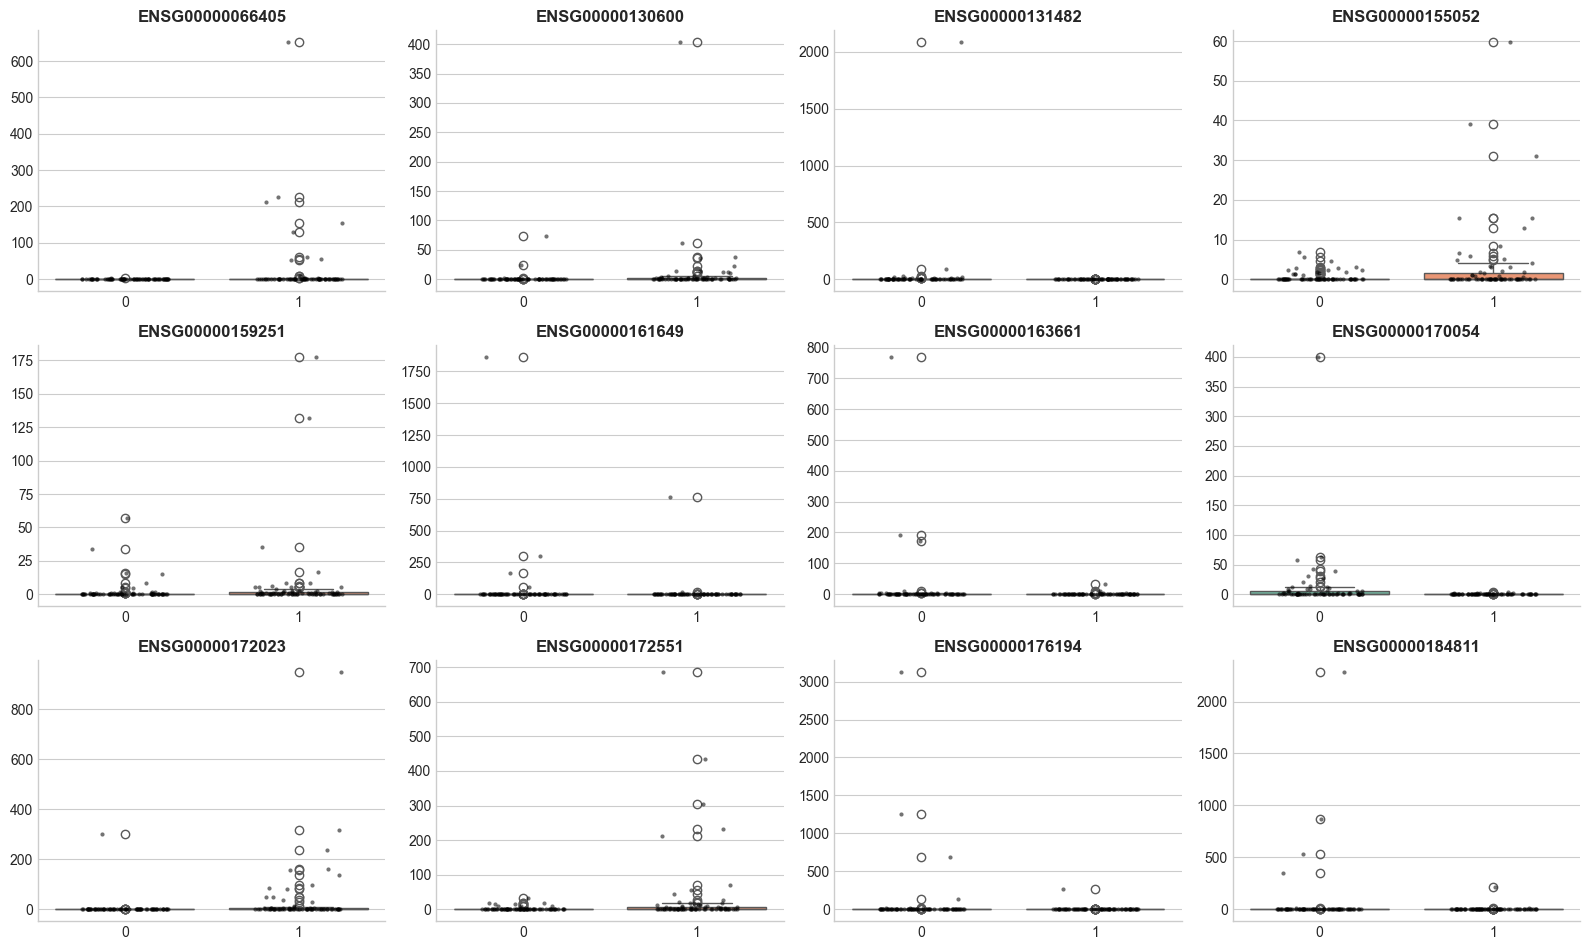

In [17]:
# ----------------------------
# 7) Boxplots for top core genes (up to 12, publication quality)
# ----------------------------
def plot_boxplots(gene_list, fname):
    if len(gene_list) == 0:
        print(f"No genes to plot for {fname}")
        return

    # Select first 12 genes
    top = gene_list[:12]
    n = len(top)

    # Grid layout
    cols = min(4, n)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.2 * rows))
    axes = axes.flatten()

    # Ensure y is categorical with consistent ordering
    label_order = sorted(y.unique()) if hasattr(y, "unique") else None

    for i, gene in enumerate(top):
        ax = axes[i]

        df = pd.DataFrame({
            "Expression (scaled)": feature_scaled[gene],
            "Group": y
        })

        # Boxplot with clean style
        sns.boxplot(
            x="Group",
            y="Expression (scaled)",
            data=df,
            ax=ax,
            palette="Set2",
            linewidth=1,
            order=label_order
        )

        # Strip points
        sns.stripplot(
            x="Group",
            y="Expression (scaled)",
            data=df,
            ax=ax,
            color="black",
            size=3,
            jitter=0.25,
            alpha=0.55,
            order=label_order
        )

        ax.set_title(gene, fontsize=12, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Remove spines for cleaner publication look
        sns.despine(ax=ax)

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    # Output paths
    png_out = os.path.join(OUTDIR, f"boxplots_{fname}.png")
    pdf_out = os.path.join(OUTDIR, f"boxplots_{fname}.pdf")
    svg_out = os.path.join(OUTDIR, f"boxplots_{fname}.svg")

    # High-resolution and vector outputs
    plt.savefig(png_out, dpi=600, bbox_inches="tight")
    plt.savefig(pdf_out, bbox_inches="tight")
    plt.savefig(svg_out, bbox_inches="tight")

    #plt.close()
    print(f"Saved boxplots: {png_out}, {pdf_out}, {svg_out}")


# Run for core genes
plot_boxplots(core_genes, "core_genes_top12")



In [15]:

# ----------------------------
# 8) ROC-AUC evaluation (cross-validated) for:
#    - LASSO model (full features)
#    - SVM model (full features)
#    - Ensemble/core-gene logistic model (trained on core_genes)
# ----------------------------
print("\n=== ROC-AUC (CV) evaluation ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# helper to cross-validate predicted probabilities (prob for class 1)
def cv_pred_proba(model, X, y, cv):
    # cross_val_predict with method='predict_proba' used where possible
    try:
        probs = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    except:
        # fallback: use decision_function and sigmoid
        preds = cross_val_predict(model, X, y, cv=cv, method="decision_function", n_jobs=-1)
        # map to [0,1] via logistic
        probs = 1 / (1 + np.exp(-preds))
    return probs

# LASSO (use full scaled features)
model_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=5000)
probs_lasso = cv_pred_proba(model_lasso, feature_scaled, y_enc, cv)
auc_lasso = roc_auc_score(y_enc, probs_lasso)
results.append(("LASSO_full", auc_lasso))
print("LASSO (full) AUC:", auc_lasso)

# SVM (full features) -> use probability=True for SVC
model_svm = SVC(kernel="linear", probability=True)
probs_svm = cv_pred_proba(model_svm, feature_scaled, y_enc, cv)
auc_svm = roc_auc_score(y_enc, probs_svm)
results.append(("SVM_full", auc_svm))
print("SVM (full) AUC:", auc_svm)

# Ensemble/core genes logistic
if len(core_genes) >= 1:
    X_core = feature_scaled[core_genes]
    model_core = LogisticRegression(solver="liblinear", penalty="l2", max_iter=5000)
    probs_core = cv_pred_proba(model_core, X_core, y_enc, cv)
    auc_core = roc_auc_score(y_enc, probs_core)
    results.append(("Core_genes_lr", auc_core))
    print("Core genes LR AUC:", auc_core)
else:
    print("No core genes -> skipping core-gene ROC")

# Save results
roc_df = pd.DataFrame(results, columns=["Model", "ROC_AUC"])
roc_df.to_csv(os.path.join(OUTDIR, "roc_auc_results.csv"), index=False)
print("Saved ROC AUC results")



=== ROC-AUC (CV) evaluation ===


LASSO (full) AUC: 0.8717206790123456
SVM (full) AUC: 0.9282407407407406
Core genes LR AUC: 0.9837962962962964
Saved ROC AUC results


In [ ]:

# Optionally plot ROC curves for each model using aggregated CV predictions (if computed)
try:
    plt.figure(figsize=(6,6))
    # LASSO
    fpr, tpr, _ = roc_curve(y_enc, probs_lasso)
    plt.plot(fpr, tpr, label=f"LASSO (AUC={auc_lasso:.3f})", lw=2)
    # SVM
    fpr, tpr, _ = roc_curve(y_enc, probs_svm)
    plt.plot(fpr, tpr, label=f"SVM (AUC={auc_svm:.3f})", lw=2)
    # Core if present
    if len(core_genes) >= 1:
        fpr, tpr, _ = roc_curve(y_enc, probs_core)
        plt.plot(fpr, tpr, label=f"Core LR (AUC={auc_core:.3f})", lw=2)
    plt.plot([0,1],[0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Cross-validated ROC curves")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "roc_cv_models.png"), dpi=300)
    plt.close()
    print("Saved ROC plot")
except Exception as e:
    print("Could not plot ROC curves:", e)

# ----------------------------
# 9) Save final lists
# ----------------------------
pd.DataFrame({"lasso_genes": lasso_genes}).to_csv(os.path.join(OUTDIR, "lasso_genes.csv"), index=False)
pd.DataFrame({"svm_genes": svm_genes}).to_csv(os.path.join(OUTDIR, "svm_genes.csv"), index=False)
pd.DataFrame({"core_genes": core_genes}).to_csv(os.path.join(OUTDIR, "core_genes.csv"), index=False)
print("Saved gene lists to:", OUTDIR)

print("\n=== FINISHED ===")


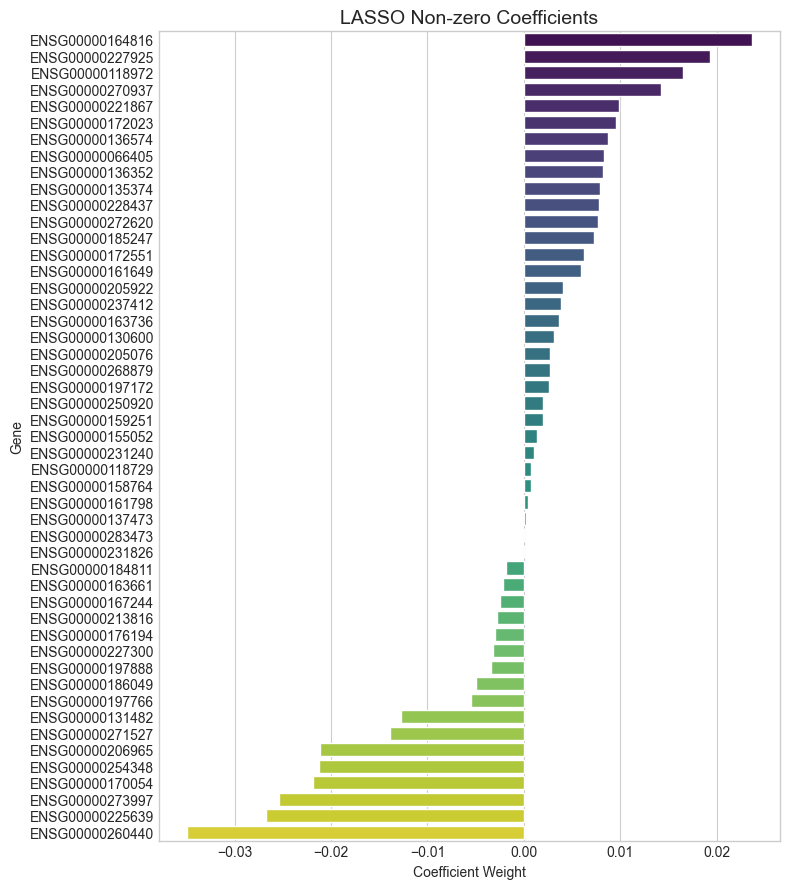

In [28]:
# --- LASSO coefficient plot ---
coef_df = pd.DataFrame({
    "Gene": lasso_genes,
    "Coefficient": lasso_coeffs
})
coef_df = coef_df.sort_values("Coefficient", ascending=False)

plt.figure(figsize=(8,9))
sns.barplot(y="Gene", x="Coefficient", data=coef_df, palette="viridis")
plt.title("LASSO Non-zero Coefficients", fontsize=14)
plt.xlabel("Coefficient Weight")
plt.ylabel("Gene")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "lasso_coefficients.png"), dpi=300)
#plt.close()


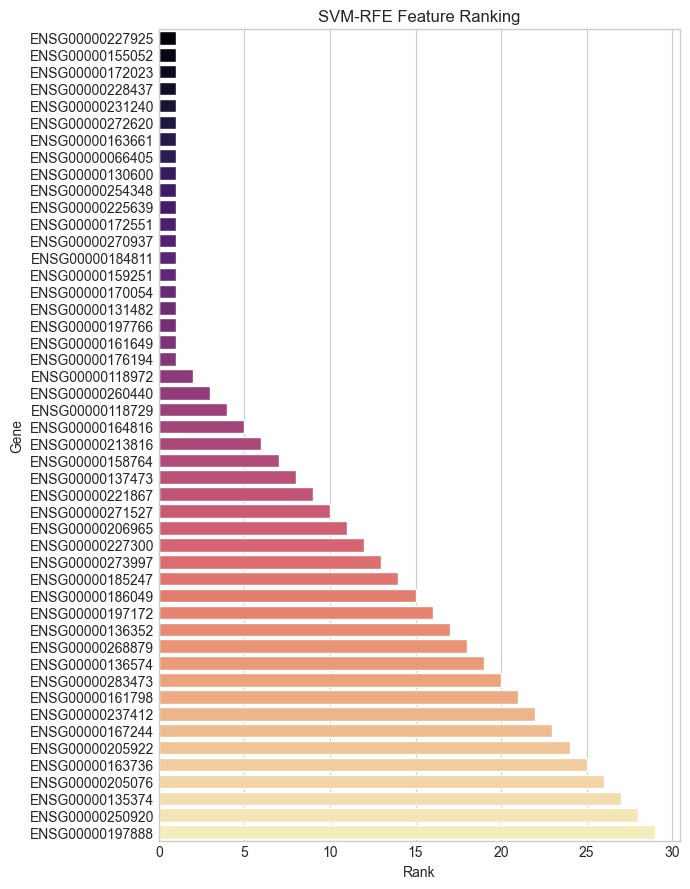

In [19]:
# SVM-RFE ranking plot
ranking = selector.ranking_
svm_rank_df = pd.DataFrame({
    "Gene": X_lasso.columns,
    "Rank": ranking
}).sort_values("Rank")

plt.figure(figsize=(7,9))
sns.barplot(y="Gene", x="Rank", data=svm_rank_df, palette="magma")
plt.title("SVM-RFE Feature Ranking")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "svm_rfe_ranking.png"), dpi=300)
#plt.close()


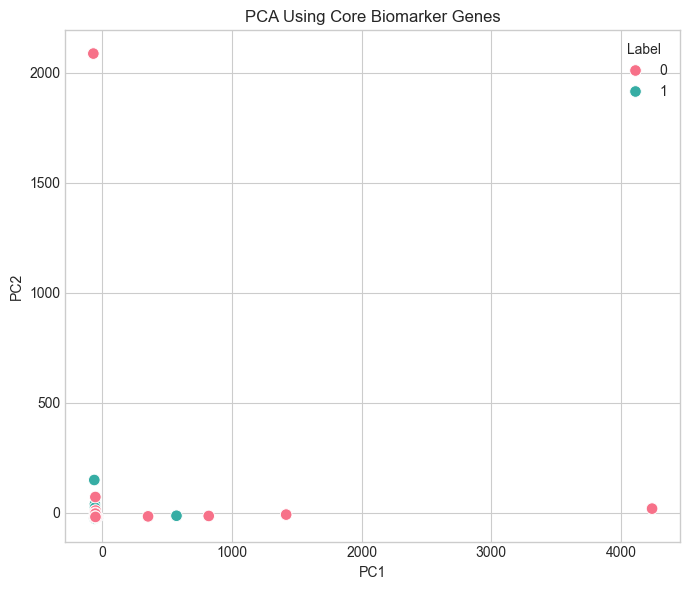

In [20]:
from sklearn.decomposition import PCA

X_core = feature_scaled[core_genes]
pca = PCA(n_components=2)
pc = pca.fit_transform(X_core)

df_pca = pd.DataFrame({"PC1": pc[:,0], "PC2": pc[:,1], "Label": y})

plt.figure(figsize=(7,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Label", s=70, palette="husl")
plt.title("PCA Using Core Biomarker Genes")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "pca_core_genes.png"), dpi=300)
#plt.close()


In [18]:
!pip install umap-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


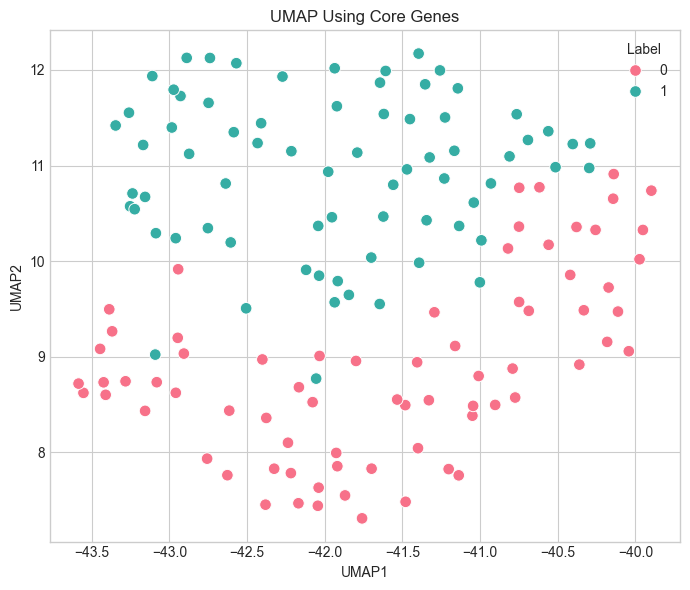

In [19]:
from umap import UMAP

um = UMAP(random_state=42)
u = um.fit_transform(X_core)

df_umap = pd.DataFrame({"UMAP1": u[:,0], "UMAP2": u[:,1], "Label": y})

plt.figure(figsize=(7,6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Label", s=70, palette="husl")
plt.title("UMAP Using Core Genes")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "umap_core_genes.png"), dpi=300)
#plt.close()


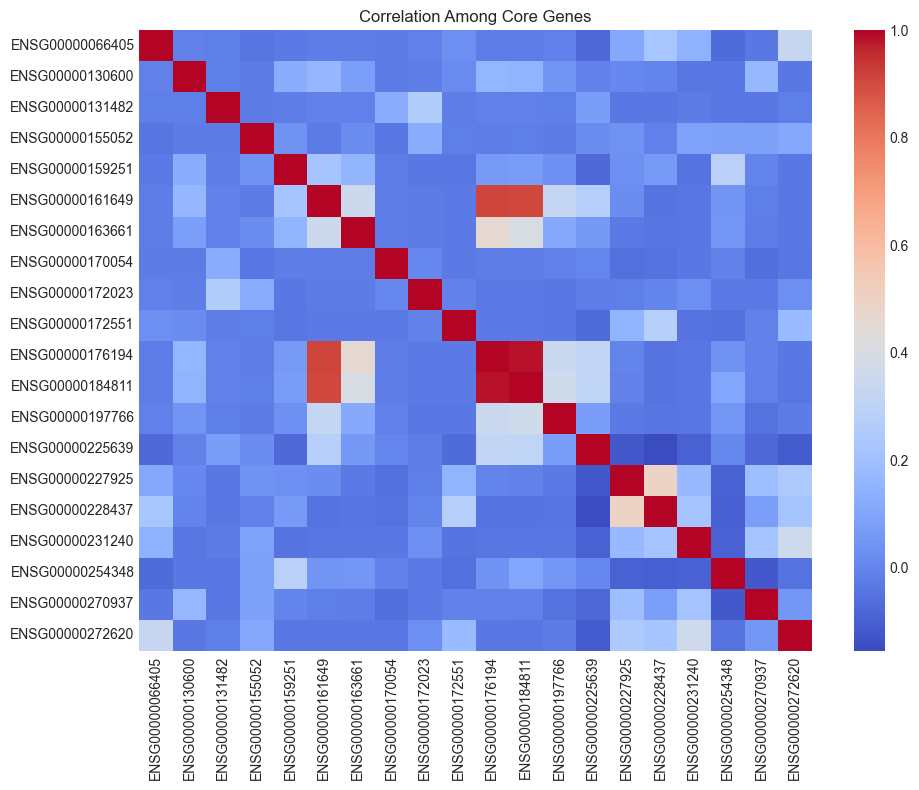

In [21]:
corr = feature_scaled[core_genes].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Among Core Genes")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "corr_core_genes.png"), dpi=300)
#plt.close()


In [23]:
# ==========================================================
#       STABILITY ANALYSIS: Bootstrap + Repeated CV
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

sns.set_style("whitegrid")

# ----------------------------------------------------------
# PARAMETERS
# ----------------------------------------------------------
N_BOOT = 200        # number of bootstrap iterations
N_SELECT_RFE = 20   # SVM-RFE selection size
OUTDIR_STAB = "figures_and_tables_lasso_svm/stability"
os.makedirs(OUTDIR_STAB, exist_ok=True)

bootstrap_records = []

print("\n=== Running Bootstrap Stability Analysis ===")

for i in range(N_BOOT):
    # Bootstrap resampling
    X_boot, y_boot = resample(feature_scaled, y_enc, replace=True)
    
    # ---------- LASSO ----------
    lasso = LogisticRegression(
        penalty='l1', solver='liblinear',
        C=best_C, max_iter=5000
    )
    lasso.fit(X_boot, y_boot)
    coef = lasso.coef_.ravel()
    lasso_genes_boot = feature_scaled.columns[coef != 0]

    # ---------- SVM-RFE ----------
    X_lasso_boot = X_boot[lasso_genes_boot]
    nsel = min(N_SELECT_RFE, X_lasso_boot.shape[1])
    
    svm_est = SVC(kernel="linear")
    rfe = RFE(svm_est, n_features_to_select=nsel)
    rfe.fit(X_lasso_boot, y_boot)
    
    svm_genes_boot = X_lasso_boot.columns[rfe.support_]

    # ---------- Intersection ----------
    core_boot = set(lasso_genes_boot).intersection(set(svm_genes_boot))

    bootstrap_records.append(list(core_boot))

    if (i+1) % 20 == 0:
        print(f"  Completed {i+1}/{N_BOOT} bootstraps")

# ----------------------------------------------------------
# Count how often each gene is selected
# ----------------------------------------------------------
from collections import Counter

all_genes = list(set(sum(bootstrap_records, [])))
counts = Counter(sum(bootstrap_records, []))

stability_df = pd.DataFrame({
    "Gene": all_genes,
    "Frequency": [counts[g] for g in all_genes],
    "Stability": [counts[g] / N_BOOT for g in all_genes]
}).sort_values("Stability", ascending=False)

stability_df.to_csv(f"{OUTDIR_STAB}/bootstrap_stability_scores.csv", index=False)
print("\nSaved bootstrap stability frequencies.")



=== Running Bootstrap Stability Analysis ===
  Completed 20/200 bootstraps
  Completed 40/200 bootstraps
  Completed 60/200 bootstraps
  Completed 80/200 bootstraps
  Completed 100/200 bootstraps
  Completed 120/200 bootstraps
  Completed 140/200 bootstraps
  Completed 160/200 bootstraps
  Completed 180/200 bootstraps
  Completed 200/200 bootstraps

Saved bootstrap stability frequencies.


Saved stability barplot: figures_and_tables_lasso_svm/stability/bootstrap_stability_barplot.png figures_and_tables_lasso_svm/stability/bootstrap_stability_barplot.pdf figures_and_tables_lasso_svm/stability/bootstrap_stability_barplot.svg


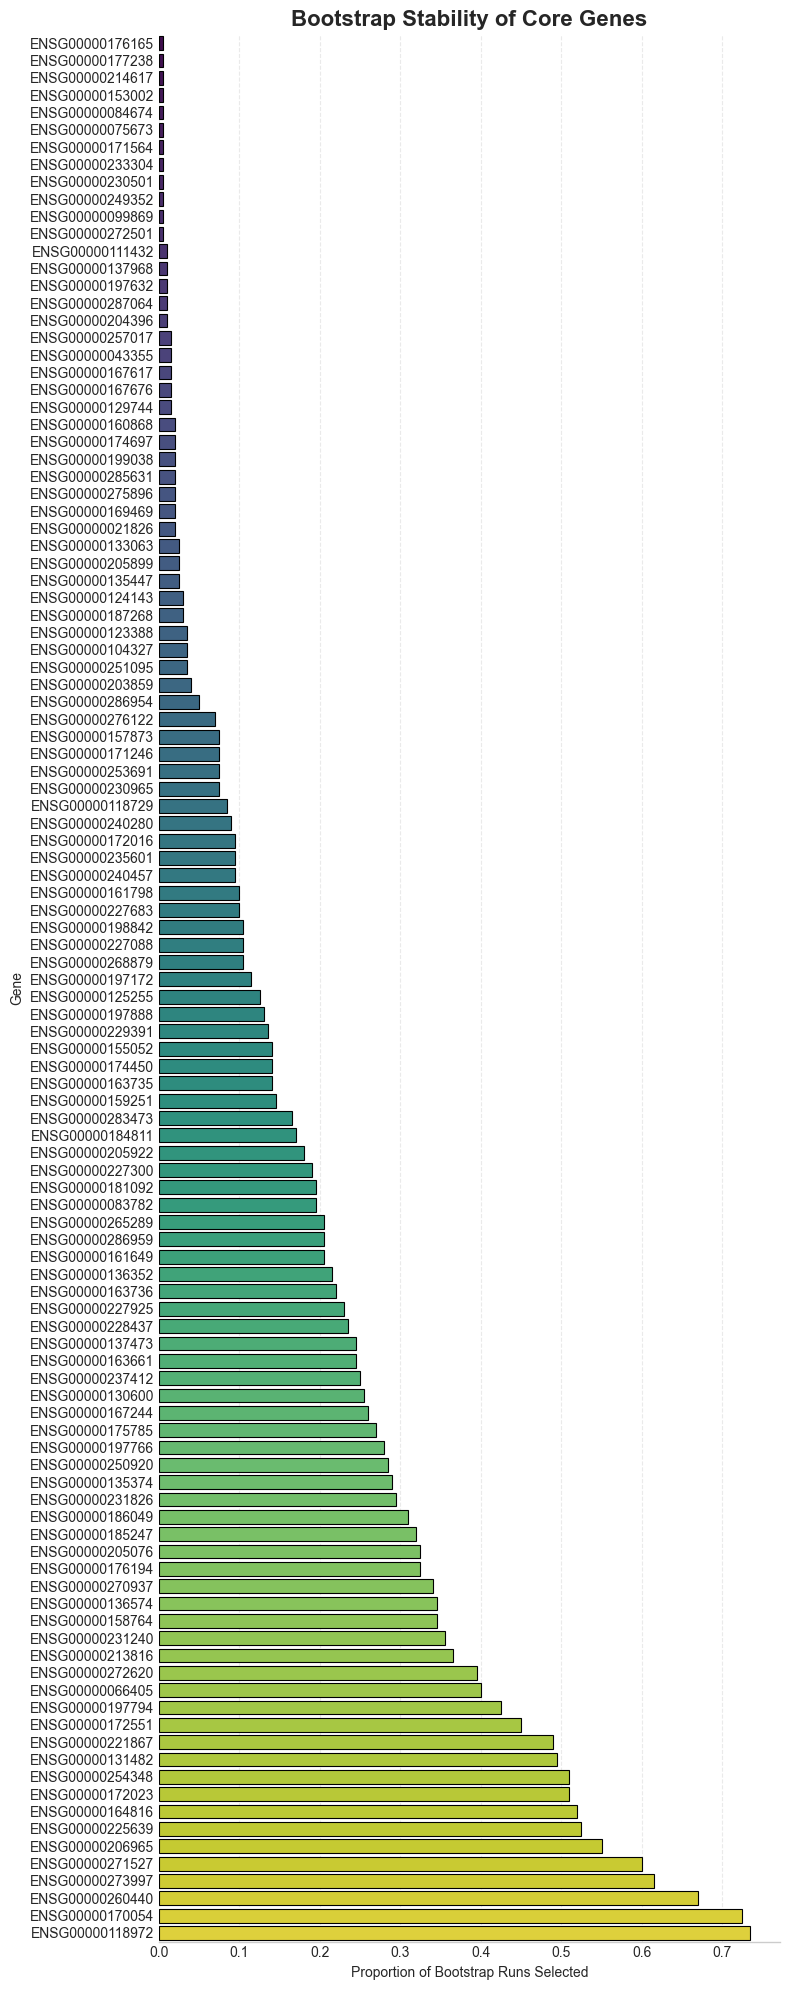

In [32]:
# ----------------------------------------------------------
# PLOT 1: Publication-quality barplot of stability
# ----------------------------------------------------------

# Sort by stability (high → low)
stability_sorted = stability_df.sort_values("Stability", ascending=True)

plt.figure(figsize=(8, 20))

sns.barplot(
    data=stability_sorted,
    x="Stability",
    y="Gene",
    palette="viridis",
    edgecolor="black",
    linewidth=0.8
)

# Title and labels
plt.title("Bootstrap Stability of Core Genes", fontsize=16, fontweight="bold")
plt.xlabel("Proportion of Bootstrap Runs Selected", fontsize=10)
plt.ylabel("Gene", fontsize=10)

# Improve tick readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Light grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Remove unnecessary spines
sns.despine(left=True, bottom=False)

plt.tight_layout()

# Paths
png_out = f"{OUTDIR_STAB}/bootstrap_stability_barplot.png"
pdf_out = f"{OUTDIR_STAB}/bootstrap_stability_barplot.pdf"
svg_out = f"{OUTDIR_STAB}/bootstrap_stability_barplot.svg"

# Save high-quality outputs
plt.savefig(png_out, dpi=600, bbox_inches="tight")
plt.savefig(pdf_out, bbox_inches="tight")
plt.savefig(svg_out, bbox_inches="tight")

#plt.close()
print("Saved stability barplot:", png_out, pdf_out, svg_out)


Saved stability barplot.


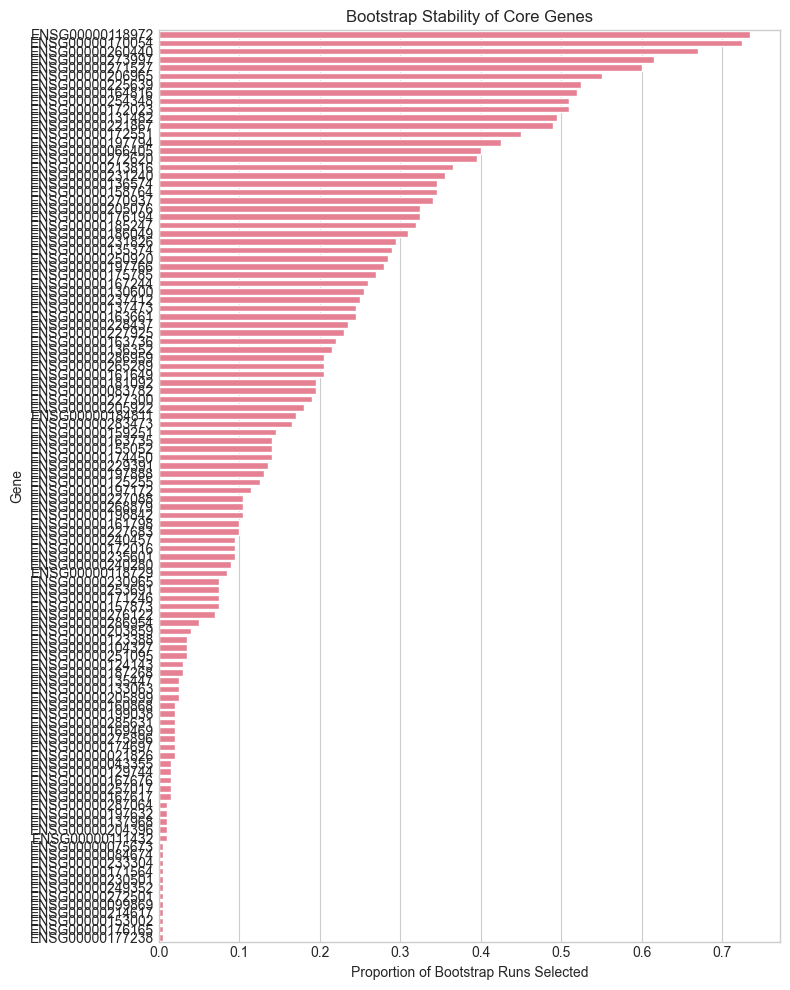

In [33]:

# ----------------------------------------------------------
# PLOT 1: Barplot of stability
# ----------------------------------------------------------
plt.figure(figsize=(8,10))
sns.barplot(data=stability_df, x="Stability", y="Gene")
plt.title("Bootstrap Stability of Core Genes")
plt.xlabel("Proportion of Bootstrap Runs Selected")
plt.tight_layout()
plt.savefig(f"{OUTDIR_STAB}/bootstrap_stability_barplot.png", dpi=300)
#plt.close()
print("Saved stability barplot.")


Saved stability heatmap.


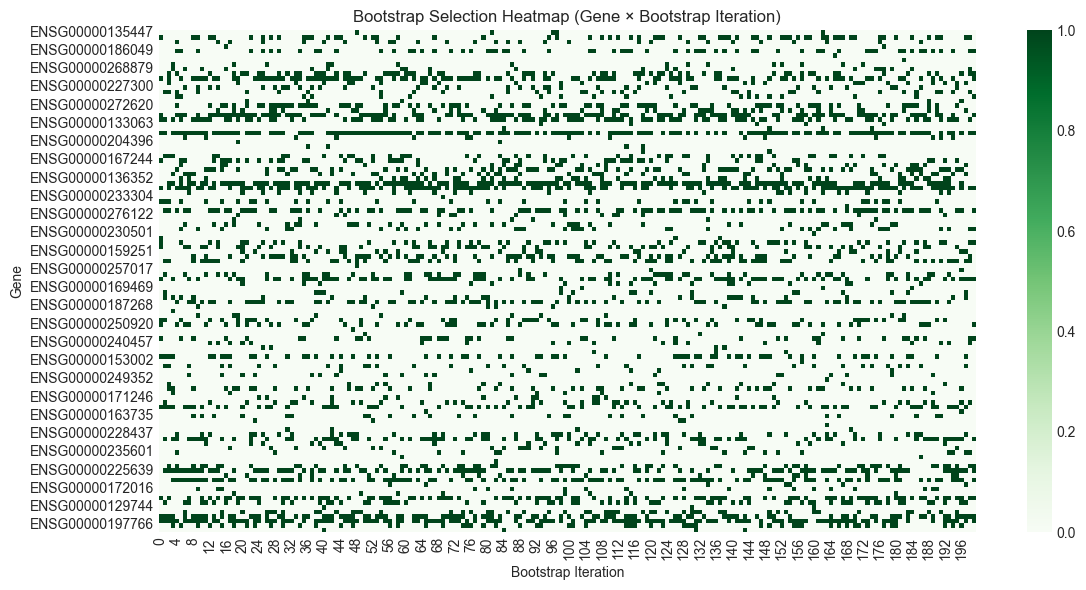

In [35]:

# ----------------------------------------------------------
# PLOT 2: Heatmap of bootstrap selections
# ----------------------------------------------------------
binary_matrix = pd.DataFrame(0, index=range(N_BOOT), columns=all_genes)
for i, boot_list in enumerate(bootstrap_records):
    for g in boot_list:
        binary_matrix.loc[i, g] = 1

plt.figure(figsize=(12,6))
sns.heatmap(binary_matrix.T, cmap="Greens", cbar=True)
plt.title("Bootstrap Selection Heatmap (Gene × Bootstrap Iteration)")
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Gene")
plt.tight_layout()
plt.savefig(f"{OUTDIR_STAB}/bootstrap_stability_heatmap.png", dpi=300)
#plt.close()
print("Saved stability heatmap.")


In [36]:

# ----------------------------------------------------------
# OPTIONAL: Repeated k-fold stability (fast version)
# ----------------------------------------------------------
print("\n=== Running Repeated CV Stability Analysis ===")
N_REPS = 50
rkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_records = []

for rep in range(N_REPS):
    for train_idx, test_idx in rkf.split(feature_scaled, y_enc):
        X_train = feature_scaled.iloc[train_idx]
        y_train = y_enc[train_idx]

        # LASSO
        lasso = LogisticRegression(
            penalty='l1', solver='liblinear',
            C=best_C, max_iter=5000
        )
        lasso.fit(X_train, y_train)
        coef = lasso.coef_.ravel()
        lasso_genes_cv = feature_scaled.columns[coef != 0]

        # SVM-RFE
        X_lasso_cv = X_train[lasso_genes_cv]
        nsel_cv = min(N_SELECT_RFE, X_lasso_cv.shape[1])
        svm_est = SVC(kernel="linear")
        rfe = RFE(svm_est, n_features_to_select=nsel_cv)
        rfe.fit(X_lasso_cv, y_train)

        svm_genes_cv = X_lasso_cv.columns[rfe.support_]

        # Intersection
        core_cv = set(lasso_genes_cv).intersection(set(svm_genes_cv))

        cv_records.append(list(core_cv))

cv_counts = Counter(sum(cv_records, []))
cv_stability_df = pd.DataFrame({
    "Gene": all_genes,
    "Frequency": [cv_counts[g] for g in all_genes],
    "Stability": [cv_counts[g] / len(cv_records) for g in all_genes]
}).sort_values("Stability", ascending=False)

cv_stability_df.to_csv(f"{OUTDIR_STAB}/cv_stability_scores.csv", index=False)
print("Saved repeated CV stability results.")



=== Running Repeated CV Stability Analysis ===
Saved repeated CV stability results.


In [37]:
import pandas as pd

boot = pd.read_csv("figures_and_tables_lasso_svm/stability/bootstrap_stability_scores.csv")
cv   = pd.read_csv("figures_and_tables_lasso_svm/stability/cv_stability_scores.csv")

print("=== Bootstrap Stability ===")
print(boot.sort_values("Stability", ascending=False).head(20))

print("\n=== Repeated CV Stability ===")
print(cv.sort_values("Stability", ascending=False).head(20))


=== Bootstrap Stability ===
               Gene  Frequency  Stability
0   ENSG00000118972        147      0.735
1   ENSG00000170054        145      0.725
2   ENSG00000260440        134      0.670
3   ENSG00000273997        123      0.615
4   ENSG00000271527        120      0.600
5   ENSG00000206965        110      0.550
6   ENSG00000225639        105      0.525
7   ENSG00000164816        104      0.520
8   ENSG00000254348        102      0.510
9   ENSG00000172023        102      0.510
10  ENSG00000131482         99      0.495
11  ENSG00000221867         98      0.490
12  ENSG00000172551         90      0.450
13  ENSG00000197794         85      0.425
14  ENSG00000066405         80      0.400
15  ENSG00000272620         79      0.395
16  ENSG00000213816         73      0.365
17  ENSG00000231240         71      0.355
18  ENSG00000136574         69      0.345
19  ENSG00000158764         69      0.345

=== Repeated CV Stability ===
               Gene  Frequency  Stability
0   ENSG000001189

In [39]:
import pandas as pd
import numpy as np
import os

# Load stability results
boot = pd.read_csv("figures_and_tables_lasso_svm/stability/bootstrap_stability_scores.csv")
cv   = pd.read_csv("figures_and_tables_lasso_svm/stability/cv_stability_scores.csv")

print("=== Bootstrap Stability ===")
print(boot.sort_values("Stability", ascending=False).head(20))

print("\n=== Repeated CV Stability ===")
print(cv.sort_values("Stability", ascending=False).head(20))

# =============================
# 1) Merge both stability tables
# =============================
merged = pd.merge(boot, cv, on="Gene", suffixes=("_bootstrap", "_cv"))

# =============================
# 2) Compute Combined Stability
# =============================
# Method: weighted mean (bootstrap 40%, CV 60%)
merged["Combined_Stability"] = (
    0.4 * merged["Stability_bootstrap"] +
    0.6 * merged["Stability_cv"]
)

# =============================
# 3) Rank genes by combined stability
# =============================
stable_ranked = merged.sort_values("Combined_Stability", ascending=False)

print("\n=== Top Stable Biomarkers (Combined Stability) ===")
print(stable_ranked.head(20))

# =============================
# 4) Save full ranked table
# =============================
outdir = "figures_and_tables_lasso_svm/stability"
os.makedirs(outdir, exist_ok=True)

stable_ranked.to_csv(os.path.join(outdir, "combined_stability_ranked_genes.csv"), index=False)

print("\nSaved combined stability table to:")
print(os.path.join(outdir, "combined_stability_ranked_genes.csv"))

# =============================
# 5) Identify HIGH, MEDIUM, LOW stability groups
# =============================
high  = stable_ranked[stable_ranked["Combined_Stability"] >= 0.70]
mid   = stable_ranked[(stable_ranked["Combined_Stability"] < 0.70) & 
                      (stable_ranked["Combined_Stability"] >= 0.40)]
low   = stable_ranked[stable_ranked["Combined_Stability"] < 0.40]

print("\n=== High Stability Genes (>=0.70) ===")
print(high)

print("\n=== Medium Stability Genes (0.40–0.69) ===")
print(mid)

print("\n=== Low Stability Genes (<0.40) ===")
print(low)

# Save the groups
high.to_csv(os.path.join(outdir, "high_stability_genes.csv"), index=False)
mid.to_csv(os.path.join(outdir, "medium_stability_genes.csv"), index=False)
low.to_csv(os.path.join(outdir, "low_stability_genes.csv"), index=False)

print("\nSaved grouped gene lists.")


=== Bootstrap Stability ===
               Gene  Frequency  Stability
0   ENSG00000118972        147      0.735
1   ENSG00000170054        145      0.725
2   ENSG00000260440        134      0.670
3   ENSG00000273997        123      0.615
4   ENSG00000271527        120      0.600
5   ENSG00000206965        110      0.550
6   ENSG00000225639        105      0.525
7   ENSG00000164816        104      0.520
8   ENSG00000254348        102      0.510
9   ENSG00000172023        102      0.510
10  ENSG00000131482         99      0.495
11  ENSG00000221867         98      0.490
12  ENSG00000172551         90      0.450
13  ENSG00000197794         85      0.425
14  ENSG00000066405         80      0.400
15  ENSG00000272620         79      0.395
16  ENSG00000213816         73      0.365
17  ENSG00000231240         71      0.355
18  ENSG00000136574         69      0.345
19  ENSG00000158764         69      0.345

=== Repeated CV Stability ===
               Gene  Frequency  Stability
0   ENSG000001189

PermissionError: [Errno 13] Permission denied: 'figures_and_tables_lasso_svm/stability\\combined_stability_ranked_genes.csv'

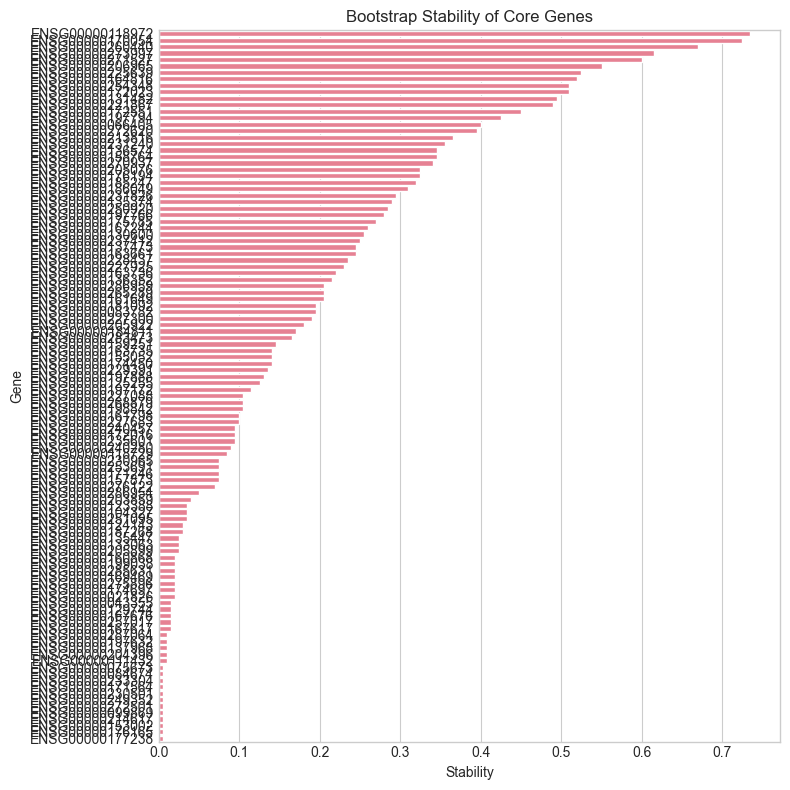

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.barplot(data=boot, x="Stability", y="Gene")
plt.title("Bootstrap Stability of Core Genes")
plt.tight_layout()
plt.show()


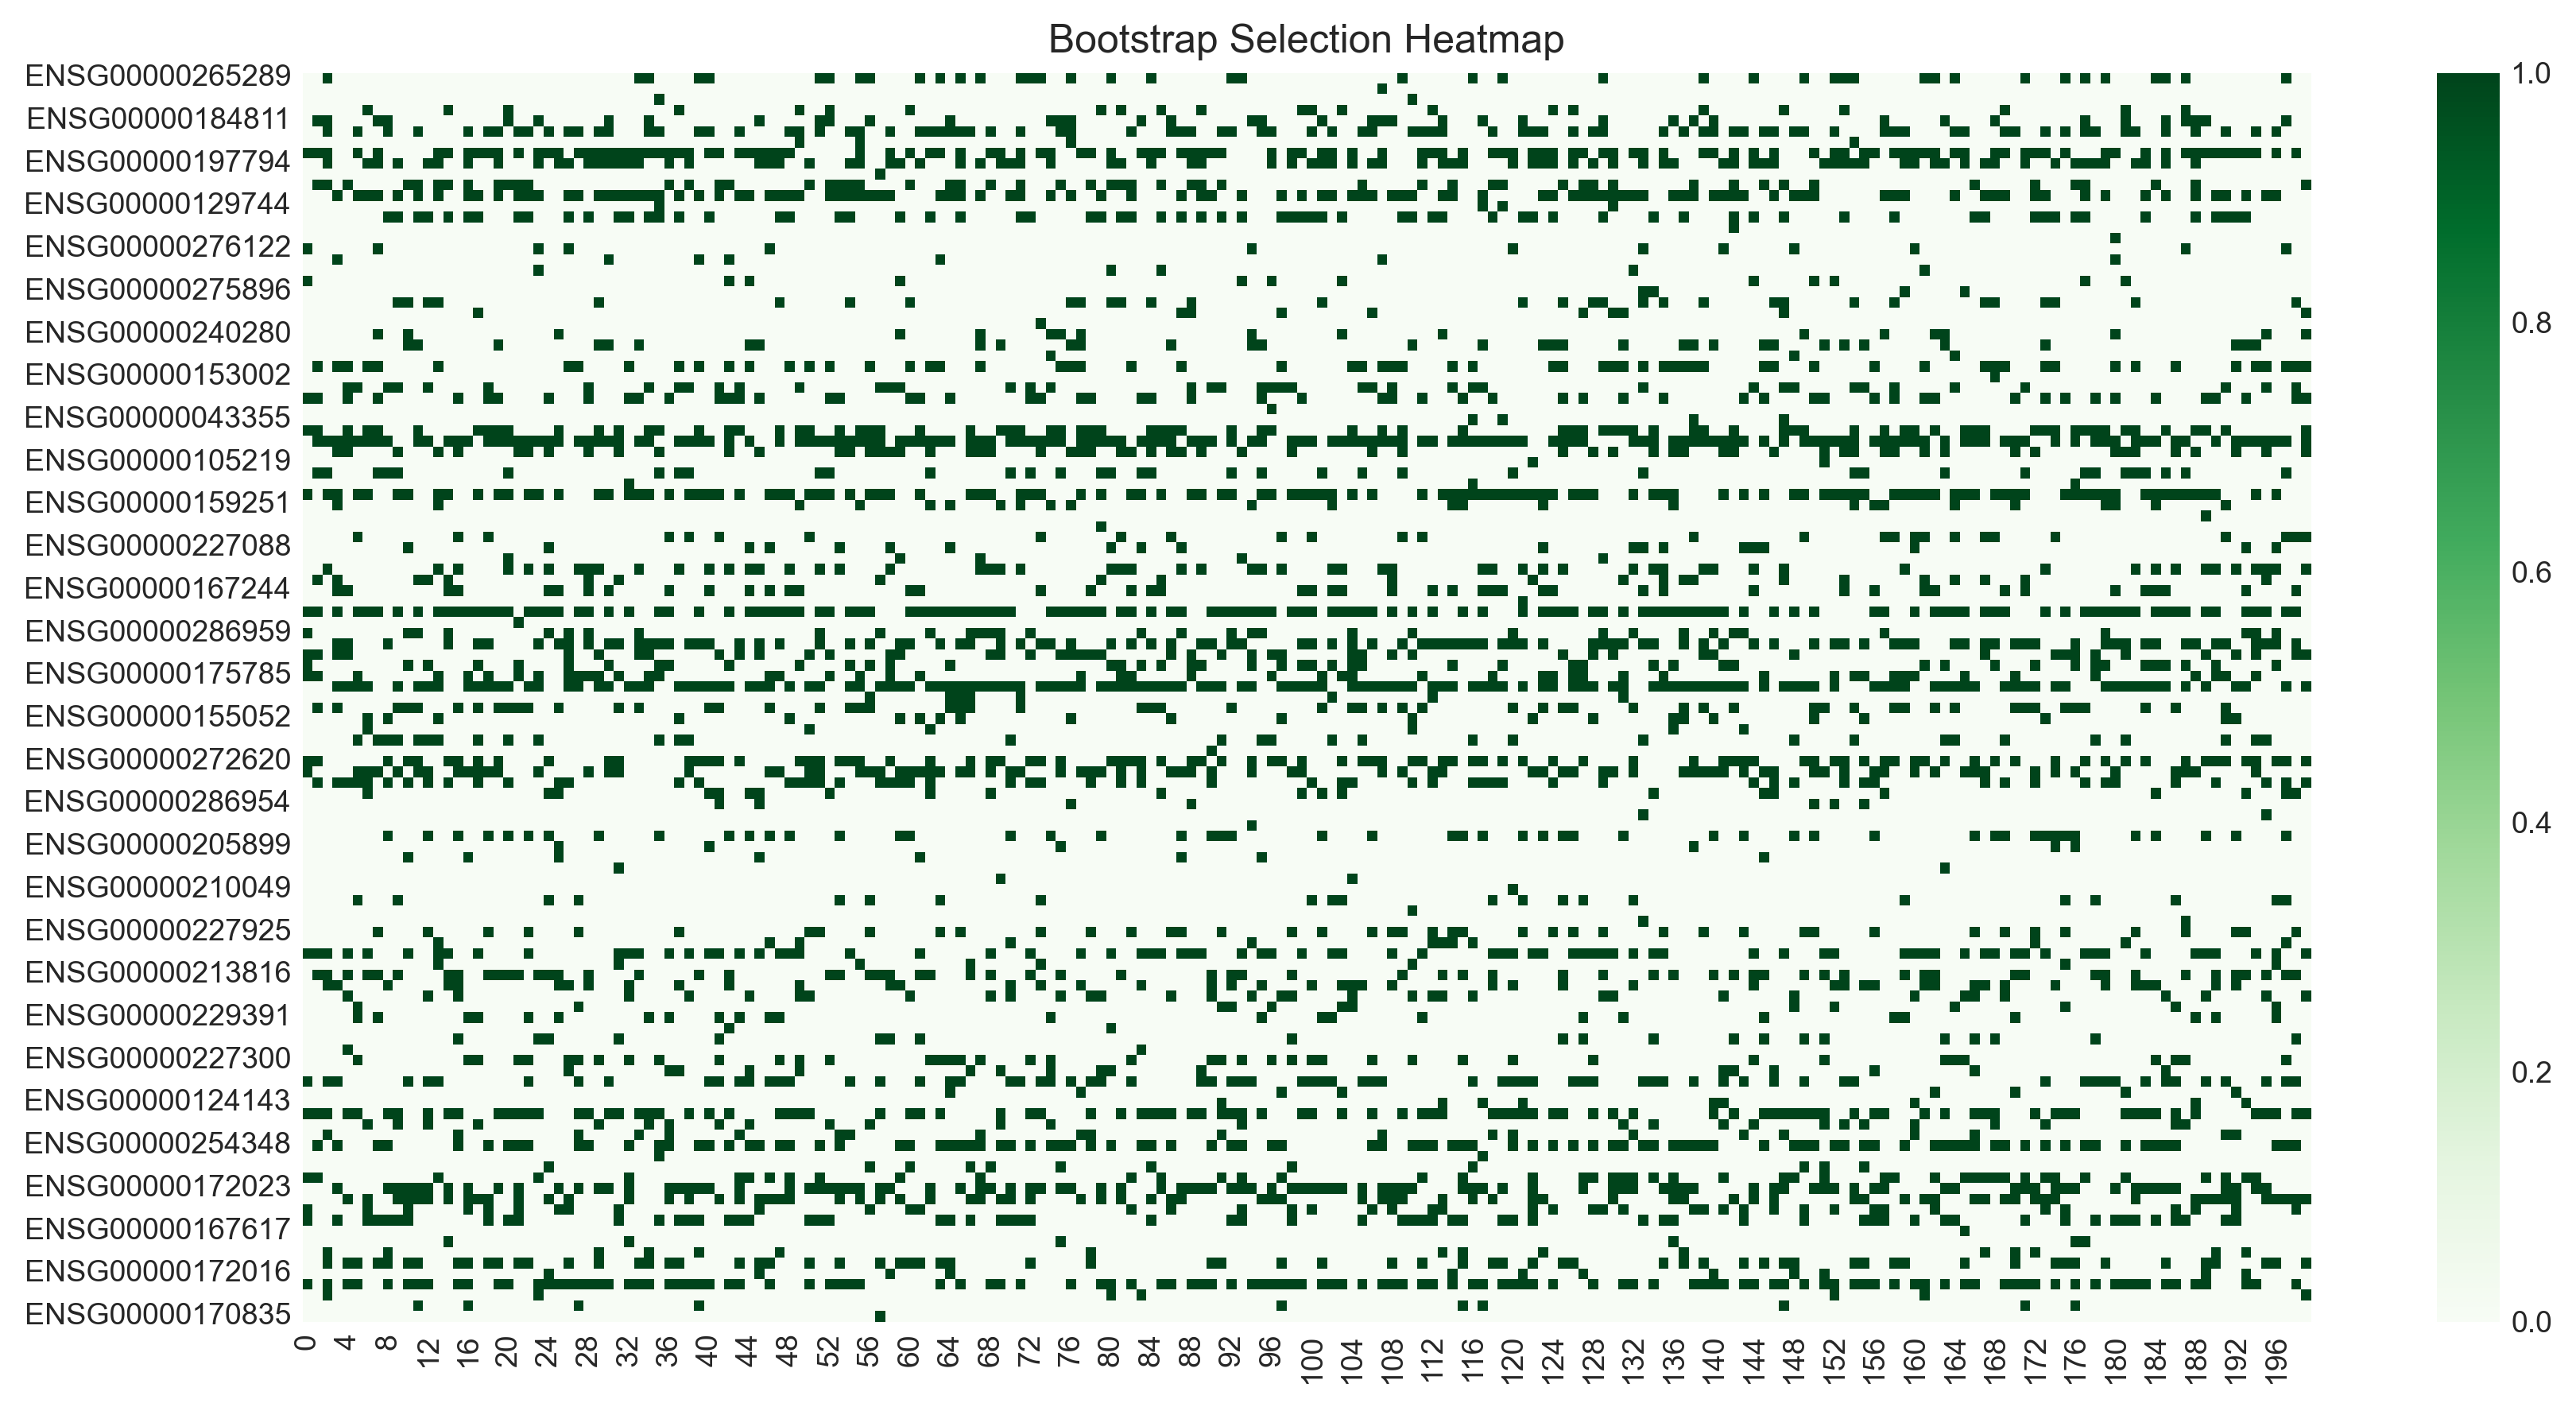

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(binary_matrix.T, cmap="Greens", cbar=True)
plt.title("Bootstrap Selection Heatmap")
plt.tight_layout()
plt.show()


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os

# ----------------------------------------
# Input data
# ----------------------------------------
# X = gene expression matrix (DataFrame: samples × genes)
# y = labels (Series or np.array)
# core_genes = list of 20 core genes

# Example:
# X = pd.read_csv("expression_matrix.csv", index_col=0)
# y = pd.read_csv("labels.csv")["label"]
# core_genes = [...]

output_dir = "individual_gene_roc_curves"
os.makedirs(output_dir, exist_ok=True)

print("Generating individual ROC curves for each core gene...\n")

# ----------------------------------------
# Function to compute ROC curve for one gene
# ----------------------------------------
def plot_gene_roc(gene, X, y, output_dir):

    # extract expression values
    Xg = X[gene].values.reshape(-1, 1)

    # scale gene (not required but recommended)
    scaler = StandardScaler()
    Xg_scaled = scaler.fit_transform(Xg).ravel()

    # compute ROC
    fpr, tpr, _ = roc_curve(y, Xg_scaled)
    auc = roc_auc_score(y, Xg_scaled)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"ROC Curve: {gene}\nAUC = {auc:.3f}", fontsize=13)
    plt.tight_layout()

    # save
    fname = f"{output_dir}/ROC_{gene}.png"
    plt.savefig(fname, dpi=300)
    #plt.close()

    return auc, fname


Generating individual ROC curves for each core gene...



In [ ]:

# ----------------------------------------
# Run for all core genes
# ----------------------------------------
results = []

for gene in core_genes:
    auc, fname = plot_gene_roc(gene, X, y, output_dir)
    results.append([gene, auc, fname])
    print(f"{gene}: AUC = {auc:.3f} → saved {fname}")

# Save table
results_df = pd.DataFrame(results, columns=["Gene", "AUC", "Plot"])
results_df.to_csv(f"{output_dir}/individual_gene_auc_summary.csv", index=False)

print("\nSaved AUC summary to:")
print(f"{output_dir}/individual_gene_auc_summary.csv")
print("\nAll ROC plots saved in:")
print(output_dir)


In [ ]:
!pip install gseapy




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# ----------------------------------------------
# CORE GENE – FUNCTIONAL ENRICHMENT ANALYSIS
# ----------------------------------------------

import os
import pandas as pd
import gseapy as gp
from gseapy.plot import barplot, dotplot
import mygene
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# -------------------------------------------------------
# Load core genes from previous pipeline
# -------------------------------------------------------
CORE_DIR = "figures_and_tables_lasso_svm"
OUTDIR = "core_gene_analysis"
os.makedirs(OUTDIR, exist_ok=True)

core_file = os.path.join(CORE_DIR, "core_genes.csv")
core_genes = pd.read_csv(core_file)["core_genes"].tolist()

print(f"Loaded {len(core_genes)} core genes.")

# -------------------------------------------------------
# Convert Ensembl IDs → Gene Symbols (required for KEGG/GO)
# -------------------------------------------------------
mg = mygene.MyGeneInfo()
gene_info = mg.querymany(core_genes, scopes="ensembl.gene", fields="symbol,name", species="human")

gene_df = pd.DataFrame(gene_info)
gene_df = gene_df[["query", "symbol", "name"]].dropna()
gene_df.columns = ["Ensembl", "Symbol", "Description"]

gene_df.to_csv(os.path.join(OUTDIR, "core_genes_annotated.csv"), index=False)
print("Saved annotated core gene list.")

core_symbols = gene_df["Symbol"].tolist()

# -------------------------------------------------------
# 1. GO Biological Process enrichment
# -------------------------------------------------------
print("\nRunning GO Biological Process (BP) enrichment...")

go_bp = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="GO_Biological_Process_2023",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)
go_bp_res = go_bp.results
go_bp_res.to_csv(os.path.join(OUTDIR, "GO_BP_results.csv"), index=False)

# Plot top 20 BP
plt.figure(figsize=(6, 8))
barplot(go_bp_res, title="GO Biological Process", top_term=20, cutoff=0.1)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "GO_BP_barplot.png"), dpi=300)
plt.close()

# -------------------------------------------------------
# 2. GO Molecular Function
# -------------------------------------------------------
print("Running GO Molecular Function (MF) enrichment...")

go_mf = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="GO_Molecular_Function_2024",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)

go_mf_res = go_mf.results
go_mf_res.to_csv(os.path.join(OUTDIR, "GO_MF_results.csv"), index=False)

plt.figure(figsize=(6,8))
barplot(go_mf_res, title="GO Molecular Function", top_term=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "GO_MF_barplot.png"), dpi=300)
plt.close()

# -------------------------------------------------------
# 3. GO Cellular Component
# -------------------------------------------------------
print("Running GO Cellular Component (CC) enrichment...")

go_cc = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="GO_Cellular_Component_2024",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)
go_cc_res = go_cc.results
go_cc_res.to_csv(os.path.join(OUTDIR, "GO_CC_results.csv"), index=False)

plt.figure(figsize=(6,8))
barplot(go_cc_res, title="GO Cellular Component", top_term=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "GO_CC_barplot.png"), dpi=300)
plt.close()

# -------------------------------------------------------
# 4. KEGG pathway enrichment
# -------------------------------------------------------
print("Running KEGG 2024 enrichment...")

kegg = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="KEGG_2024_Human",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)
kegg_res = kegg.results
kegg_res.to_csv(os.path.join(OUTDIR, "KEGG_results.csv"), index=False)

plt.figure(figsize=(6,8))
barplot(kegg_res, title="KEGG Pathways", top_term=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "KEGG_barplot.png"), dpi=300)
plt.close()

# -------------------------------------------------------
# 5. Reactome pathway enrichment
# -------------------------------------------------------
print("Running Reactome enrichment...")

reactome = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="Reactome_2024",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)
reactome_res = reactome.results
reactome_res.to_csv(os.path.join(OUTDIR, "Reactome_results.csv"), index=False)

plt.figure(figsize=(6,8))
barplot(reactome_res, title="Reactome Pathways", top_term=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "Reactome_barplot.png"), dpi=300)
plt.close()

# -------------------------------------------------------
# 6. Disease Enrichment (DisGeNET)
# -------------------------------------------------------
print("Running DisGeNET disease enrichment...")

disease = gp.enrichr(
    gene_list=core_symbols,
    gene_sets="DisGeNET",
    organism="Human",
    outdir=OUTDIR,
    cutoff=0.1
)
dis_res = disease.results
dis_res.to_csv(os.path.join(OUTDIR, "Disease_enrichment_DisGeNET.csv"), index=False)

plt.figure(figsize=(6,8))
barplot(dis_res, title="Disease Enrichment (DisGeNET)", top_term=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "DisGeNET_barplot.png"), dpi=300)
plt.close()

print("\n=== Core gene enrichment analysis COMPLETE ===")
print("All tables & plots saved in:", OUTDIR)
